<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploratory Data Analysis and Implications for SVD

Unique Users        : 200,948
Unique Movies       : 84,432
Actual Ratings      : 32,000,204
Density of Ratings  : 0.1886%


/tmp/ipython-input-3-2665482971.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


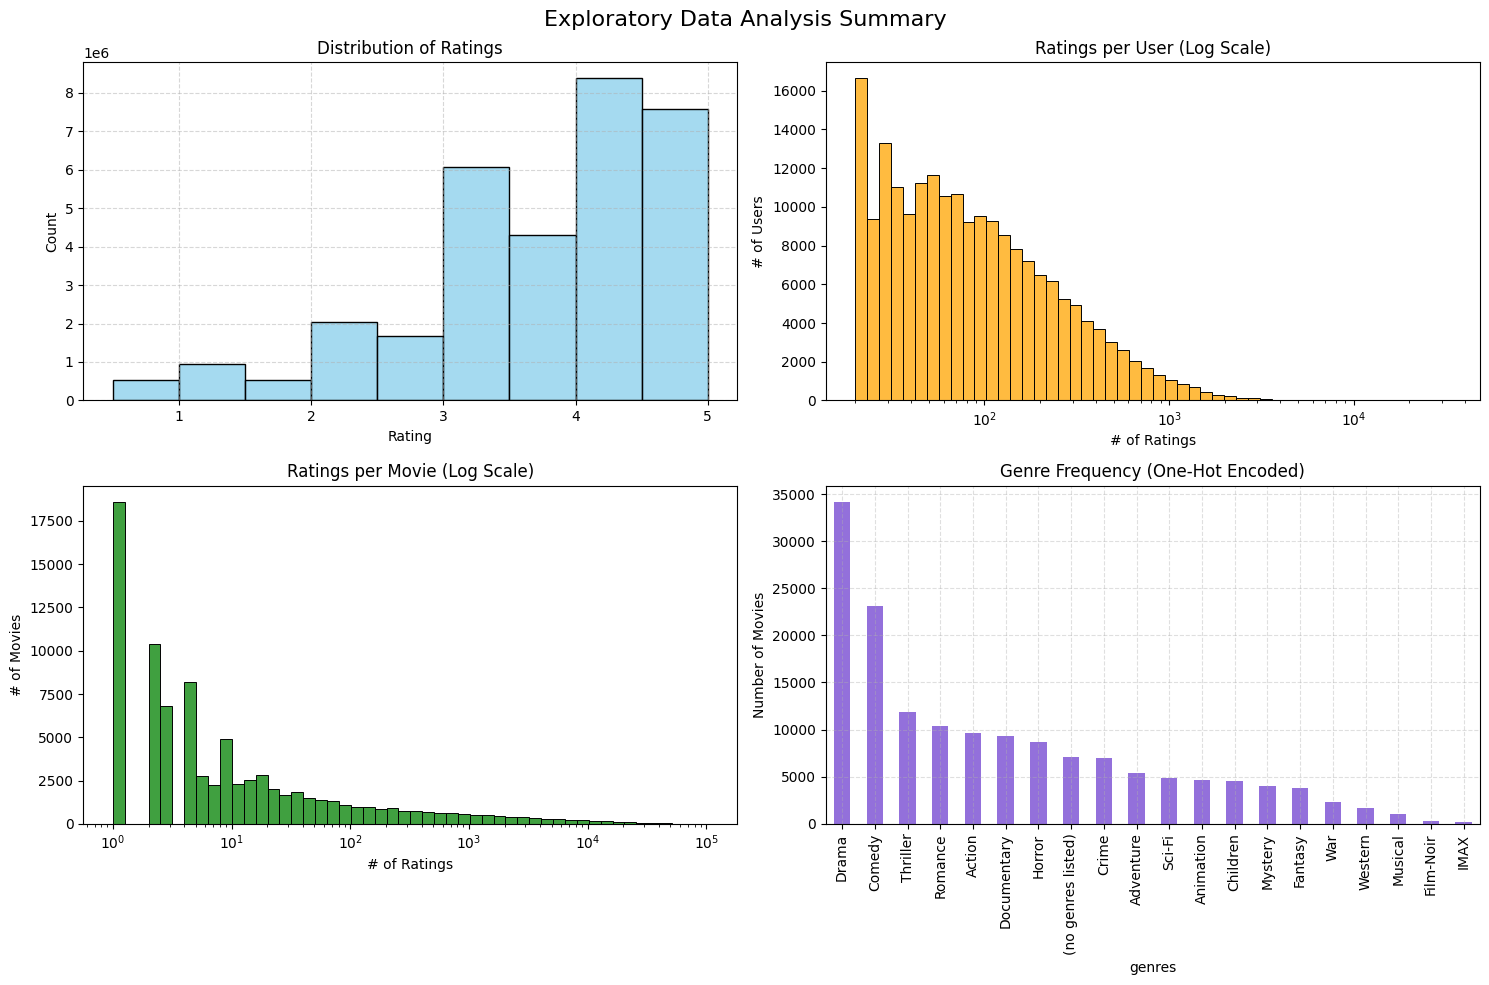

In [3]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# --- Step 1: Load Data ---
if 'ratings' not in globals():
    ratings = pd.read_csv('/content/ratings.csv')
if 'movies' not in globals():
    movies = pd.read_csv("movies.csv")

# --- Step 2: Explode Genres ---
movies['genres'] = movies['genres'].fillna('(no genres listed)').str.split('|')
movies_with_genres = movies.explode('genres').reset_index(drop=True)

# --- Step 3: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 4: Set up Faceted Layout ---
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# --- Ratings Distribution ---
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue', ax=ax1)
ax1.set_title("Distribution of Ratings")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Count")
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Ratings per User (Log Scale) ---
user_counts = ratings['userId'].value_counts()
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(user_counts, bins=50, log_scale=True, color='orange', ax=ax2)
ax2.set_title("Ratings per User (Log Scale)")
ax2.set_xlabel("# of Ratings")
ax2.set_ylabel("# of Users")

# --- Ratings per Movie (Log Scale) ---
movie_counts = ratings['movieId'].value_counts()
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(movie_counts, bins=50, log_scale=True, color='green', ax=ax3)
ax3.set_title("Ratings per Movie (Log Scale)")
ax3.set_xlabel("# of Ratings")
ax3.set_ylabel("# of Movies")

# --- Genre Frequency ---
genre_counts = movies_with_genres['genres'].value_counts()
ax4 = fig.add_subplot(gs[1, 1])
genre_counts.plot(kind='bar', color='mediumpurple', ax=ax4)
ax4.set_title("Genre Frequency (One-Hot Encoded)")
ax4.set_ylabel("Number of Movies")
ax4.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Exploratory Data Analysis Summary", fontsize=16)
plt.tight_layout()
plt.show()


**Distribution of Ratings**

* Heavy skew toward high ratings (peaks at 4 and 5).
* This means your latent dimensions may capture **positive preferences more strongly** than negative ones.
* Latent vectors will likely emphasize **"liked-item patterns"**, not dislike or neutrality.

  ***Implication:*** Apply mean-centering or z-score normalization before SVD to reduce this skew if needed.

**Ratings per User (Log Scale)**

* Long-tail distribution: most users rate few items; a small number rate hundreds or thousands.
* Latent vectors for heavy raters are **better trained** and more expressive.
* Cold-start users (few ratings) will have latent representations **closer to average or noisy**.

  ***Implication:*** Consider assigning **user confidence weights** (e.g., in matrix factorization with regularization).


**Ratings per Movie (Log Scale)**

* Also a long-tail: few movies are heavily rated, many have <10 ratings.
* Latent features of niche movies will be **less stable**, may act as noise in similarity computations.
* Popular movies will dominate early latent factors unless normalized.

  ***Implication:*** You might apply **shrinkage**, **IUF**, or **regularization** to avoid overfitting to high-volume items.

**Genre Frequency (One-Hot Encoded)**

* *Drama*, *Comedy*, *Thriller*, and *Romance* dominate.
* These genres will **anchor** some of the major latent dimensions during SVD.
* Less common genres (e.g., *Musical*, *Western*) might get grouped together in later, smaller-magnitude dimensions.

  ***Implication:*** When analyzing movie projections along dimensions, check genre concentrations to **interpret latent axes**.

**What This Tells You About Latent Dimensions:**

* **Ratings skewed toward 4–5**
  : Latent space becomes biased toward modeling *preference*, not *dislike*.

* **Users and movies follow a power-law distribution**
  : Dominant latent vectors are shaped by *popular users and movies*.

* **Genre imbalance**
  : Early latent dimensions may reflect distinctions between *popular genres* (e.g., Drama vs. Action).

* **Sparse corners in the matrix**
  : Cold-start users and niche movies tend to cluster around *average* or *neutral* regions in latent space.


### **Methodology for Sampling Ratings Data for Matrix Factorization**

* **Load and Merge Datasets**
  Load the `ratings.csv` and `movies.csv` files, and merge them on the `movieId` field to associate each rating with movie metadata (including genre). Fill in missing genres with a placeholder string to avoid null handling issues during processing.

* **Filter for Active Users**
  Compute the number of ratings and the average rating for each user. To focus on users with meaningful activity, select users who have rated at least 100 movies. Then segment these active users into quartiles based on their average rating behavior and retain the top 10,000 by number of ratings. This ensures both consistency and diversity in user behavior.

* **Assign Weights to Genres Based on Rarity**
  Calculate how frequently each genre appears in the dataset. Infrequent genres are assigned higher weights (via inverse frequency normalization) to promote genre diversity in the sampled movie subset. This ensures that popular genres don’t dominate the sampled dataset.

* **Sample Movies Using Genre Weights**
  Extract a distinct list of movies and their associated genres. Using the genre-based weights, randomly sample 5,000 movies such that rarer genres have a higher probability of selection. This creates a more balanced genre representation in the sampled data.

* **Construct a Stratified Ratings Subset**
  Filter the merged ratings dataset to retain only ratings for the sampled movies. To ensure user profiles remain informative, keep only those users who have rated at least 10 of the sampled movies. This step maintains data density and avoids extremely sparse user vectors.

* **Split into Train and Test Sets**
  Perform a random 80/20 train-test split on the stratified ratings subset. The training data is used to learn latent factors via matrix factorization, while the test data can be used to evaluate prediction accuracy (e.g., RMSE, MAE).

This methodology ensures that the sampled dataset remains representative and useful for building a recommender system, while significantly reducing the computational load for matrix factorization tasks like SVD.


Trying: 5000 users, 5246 movies → Sparsity: 0.7847

Final Matrix Summary
Users: 5000, Movies: 5246
Sparsity: 0.7847 (78.47% empty)
Train size: (4517169, 4), Test size: (1129293, 4)
Density of Ratings  : 21.5267%


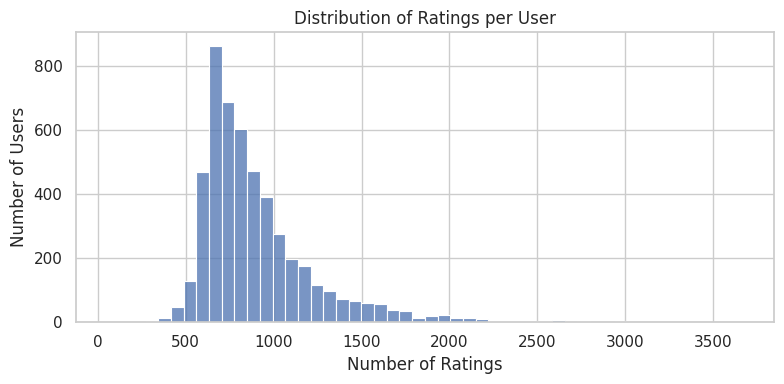

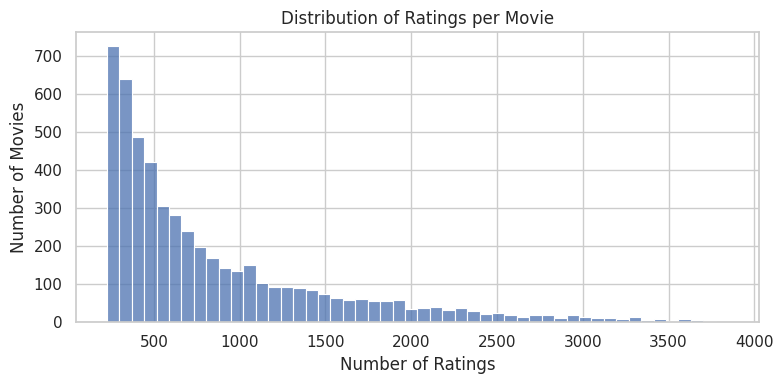

In [4]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

# --- Step 1: Load Ratings Data ---
if 'ratings' not in globals():
    ratings = pd.read_csv("ratings.csv")

# --- Step 2: Define Sparsity Optimization Parameters ---
target_sparsity = 0.80  # Desired maximum sparsity
min_user_ratings = 300
min_movie_ratings = 300
# min_user_ratings = 100
# min_movie_ratings = 50
best_sparsity = 1.0
user_step = 1000
movie_step = 2000
max_users = 6000
max_movies = 40000

# --- Step 3: Optimize Sampling ---
for user_limit in range(5000, max_users + 1, user_step):
    # Filter users with at least 100 ratings
    user_counts = ratings['userId'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index[:user_limit]
    user_filtered = ratings[ratings['userId'].isin(active_users)]

    # Filter movies with at least 50 ratings
    movie_counts = user_filtered['movieId'].value_counts()
    popular_movies = movie_counts[movie_counts >= min_movie_ratings].index[:max_movies]
    movie_filtered = user_filtered[user_filtered['movieId'].isin(popular_movies)]

    # Retain users with at least 10 ratings in the filtered data
    eligible_users = movie_filtered['userId'].value_counts()
    eligible_users = eligible_users[eligible_users >= 10].index
    stratified_df = movie_filtered[movie_filtered['userId'].isin(eligible_users)]

    # Create user-movie matrix and compute sparsity
    if stratified_df.empty:
        continue

    user_movie_matrix = stratified_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    num_users, num_movies = user_movie_matrix.shape
    total_possible = num_users * num_movies
    actual_ratings = (user_movie_matrix > 0).sum().sum()
    sparsity = 1 - (actual_ratings / total_possible)

    print(f"Trying: {num_users} users, {num_movies} movies → Sparsity: {sparsity:.4f}")

    if sparsity < best_sparsity:
        best_sparsity = sparsity
        best_matrix = user_movie_matrix.copy()
        best_stratified_df = stratified_df.copy()

    if sparsity <= target_sparsity:
        break

# --- Step 4: Final Train-Test Split ---
train_ratings, test_ratings = train_test_split(best_stratified_df, test_size=0.2, random_state=42)

# --- Step 5: Report Final Matrix ---
num_users, num_movies = best_matrix.shape
total_possible = num_users * num_movies
actual_ratings = (best_matrix > 0).sum().sum()
final_sparsity = 1 - (actual_ratings / total_possible)


num_users = best_stratified_df['userId'].nunique()
num_movies = best_stratified_df['movieId'].nunique()
actual_ratings = len(best_stratified_df)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print("\nFinal Matrix Summary")
print(f"Users: {num_users}, Movies: {num_movies}")
print(f"Sparsity: {final_sparsity:.4f} ({final_sparsity * 100:.2f}% empty)")
print(f"Train size: {train_ratings.shape}, Test size: {test_ratings.shape}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 6: Visualize Rating Distributions ---
user_rating_counts = train_ratings['userId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_rating_counts, bins=50)
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

movie_rating_counts = train_ratings['movieId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(movie_rating_counts, bins=50)
plt.title("Distribution of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


### Methodology for Creating the User-Movie Matrix:

* **Load Ratings Data**
  The ratings data is imported from the `ratings.csv` file using pandas. This dataset includes columns such as `userId`, `movieId`, and `rating`, representing individual user ratings for specific movies. Loading it into a DataFrame provides a structured format for transformation.

* **Create User-Movie Ratings Matrix**
  The long-format DataFrame is pivoted to form a matrix where rows correspond to users, columns correspond to movies, and the cell values are the ratings. This transformation reorganizes the data into a user-item matrix format required for matrix factorization techniques.

* **Handle Missing Values**
  Many users have not rated all movies, resulting in missing values (NaN) in the matrix. These missing values are filled with zeros to produce a complete numeric matrix. This step is essential for applying standard SVD, which requires all matrix entries to be defined.

* **Inspect the Matrix Structure**
  The shape and content of the matrix are reviewed to confirm that the transformation was successful. This includes checking the number of users and movies represented and viewing sample rows to ensure the matrix is properly structured and ready for downstream analysis.


### Center the Matrix (Remove Bias)

**Why This Matters for SVD**

* SVD works best on data with **zero-mean rows**, so the decomposition captures **relative preferences**.
* It reveals **latent dimensions** that explain *why* a user rates higher/lower — not just how *high* they rate in general.
* Without this step, SVD may waste components explaining rating bias instead of *preference structure*.


In [5]:
# Center by user (common for collaborative filtering)

# Step 1: Replace 0s with np.nan so they are ignored in mean calculation
user_means = best_matrix.replace(0, np.nan).mean(axis=1)

# Step 2: Subtract user means to center ratings
matrix_centered = best_matrix.sub(user_means, axis=0).fillna(0)


### Step 3: Convert to Sparse Format (if needed)

In [6]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(matrix_centered.values)

### Perform Truncated SVD

Choose k (number of latent dimensions). Start with 20–50.

In [10]:
from scipy.sparse.linalg import svds

k = 20  # You can try 50, 100 later
U, sigma, Vt = svds(sparse_matrix, k=k)


### Step 3: Reconstruct the Centered Matrix

In [11]:
# Convert sigma to diagonal matrix
sigma_diag = np.diag(sigma)

# Reconstruct the centered ratings matrix
predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)


### Step 4: Add Back User Means

In [12]:
# Add back user means to get the final predicted ratings
user_means_array = user_means.values.reshape(-1, 1)
predicted_ratings = predicted_centered + user_means_array

# Convert to DataFrame for easier viewing
predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)


### Step 5: Generate Top-N Movie Recommendations for Each User

In [ ]:
def get_top_n_recommendations(user_id, predictions_df, original_ratings_df, movies_df, n=10):
    # Movies the user already rated
    rated_movies = original_ratings_df[original_ratings_df['userId'] == user_id]['movieId'].tolist()

    # Get predicted ratings for that user
    user_predictions = predictions_df.loc[user_id]

    # Filter out rated movies
    recommendations = user_predictions.drop(labels=rated_movies)

    # Sort and select top-N
    top_n = recommendations.sort_values(ascending=False).head(n).reset_index()
    top_n.columns = ['movieId', 'predicted_rating']

    # Merge with movie titles
    top_n = top_n.merge(movies_df[['movieId', 'title']], on='movieId', how='left')

    # Reorder columns
    return top_n[['title', 'predicted_rating']]

# Example usage
sample_user_id = predicted_df.index[0]
top_n = get_top_n_recommendations(sample_user_id, predicted_df, best_stratified_df, movies, n=10)

print("Top 10 Recommended Movies for User", sample_user_id)
print(top_n)


In [13]:
def get_top_n_recommendations(user_id, predictions_df, original_ratings_df, n=10):
    # Movies already rated by this user
    rated_movies = original_ratings_df[original_ratings_df['userId'] == user_id]['movieId'].tolist()

    # Predicted ratings for all movies for this user
    user_predictions = predictions_df.loc[user_id]

    # Filter out movies the user has already rated
    recommendations = user_predictions.drop(labels=rated_movies)

    # Sort movies by predicted rating
    top_recommendations = recommendations.sort_values(ascending=False).head(n)

    return top_recommendations

# Replace with a userId from your dataset
sample_user_id = predicted_df.index[0]

top_n = get_top_n_recommendations(sample_user_id, predicted_df, best_stratified_df, n=10)
print("Top 10 Recommended Movies for User", sample_user_id)
print(top_n)



Top 10 Recommended Movies for User 28
movieId
6979    4.185487
3176    4.105295
4489    4.023129
2324    3.978432
785     3.944833
1258    3.909714
2336    3.677702
2391    3.669689
8984    3.611685
1449    3.611295
Name: 28, dtype: float64


### Step 6: Evaluate Prediction Accuracy (Optional but Recommended)

Evaluate how well the predictions match actual ratings in your test set.

In [14]:
# Compute Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Efficiently pull predictions only for test set
def get_prediction(row):
    try:
        return predicted_df.at[row['userId'], row['movieId']]
    except KeyError:
        return np.nan  # In case the user or movie is missing

# Apply row-wise prediction extraction
test_ratings['predicted_rating'] = test_ratings.apply(get_prediction, axis=1)

# Drop any missing predictions
valid_predictions = test_ratings.dropna(subset=['predicted_rating'])

# Evaluate
rmse = np.sqrt(mean_squared_error(valid_predictions['rating'], valid_predictions['predicted_rating']))
mae = mean_absolute_error(valid_predictions['rating'], valid_predictions['predicted_rating'])
r2 = r2_score(valid_predictions['rating'], valid_predictions['predicted_rating'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")




RMSE: 1.8091
MAE : 1.5193
R²  : -2.1003


### Step 7: Visualizations

#### Step 7.1: Scree Plot of Singular Values

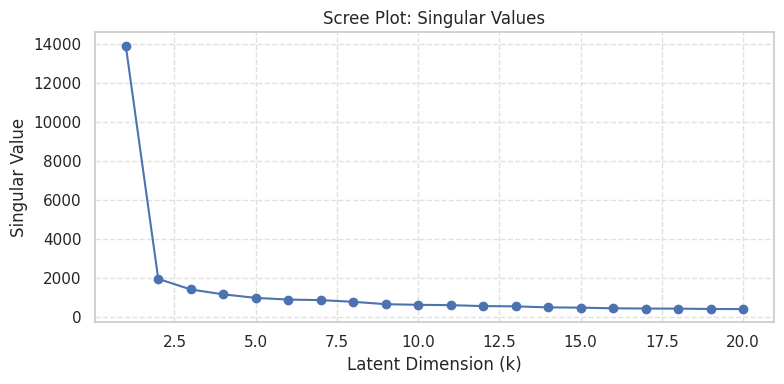

In [15]:
import matplotlib.pyplot as plt

# Sort singular values in descending order
sorted_sigma = np.sort(sigma)[::-1]

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(sorted_sigma) + 1), sorted_sigma, marker='o')
plt.title("Scree Plot: Singular Values")
plt.xlabel("Latent Dimension (k)")
plt.ylabel("Singular Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This *Scree Plot* shows the **singular values** (y-axis) across the **first 20 latent dimensions** (x-axis), which helps assess how much variance or "energy" each dimension captures in the SVD decomposition.

**Key Observations:**

* **Sharp Drop After First Dimension**:

  * The **first singular value** is extremely dominant (\~14,000), indicating it captures the **majority of the variance**.
  * The second singular value drops drastically (\~2,000), with all subsequent ones gradually tapering off.
* **Elbow Shape (Dim 1–3)**:

  * The plot shows a classic **"elbow"** around the first few components (roughly 2–3), suggesting **diminishing returns** beyond these.
* **Long Tail**:

  * After \~dimension 5, singular values continue to drop but more slowly.
  * This implies the remaining latent factors contribute less individually but may still be useful collectively for fine-grained structure.

**Interpretation:**

* The first few latent dimensions are **critical** for capturing major patterns (e.g., popularity, genre clusters).
* Beyond the elbow, additional dimensions contribute **incremental nuance**, which may help **improve recommendations** but with reduced impact.

**Insight:**

* Choose **k = 10 to 20** latent factors for **a balance** between variance capture and model complexity.


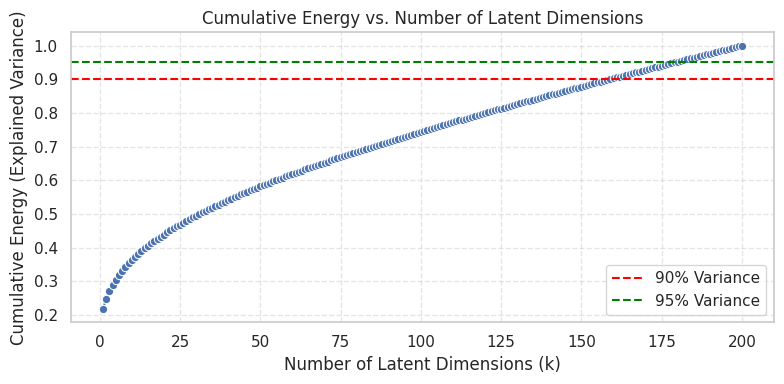

In [26]:
from scipy.sparse.linalg import svds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run full SVD (or large k to capture most energy)
k_max = 200  # Adjust based on memory
U, sigma, Vt = svds(sparse_matrix, k=k_max)
sigma = np.sort(sigma)[::-1]  # Sort descending

# Step 2: Compute cumulative energy and explained variance ratio
total_energy = np.sum(sigma)
explained_variance_ratio = sigma / total_energy
cumulative_energy = np.cumsum(explained_variance_ratio)

# Step 3: Create DataFrame for plotting
energy_df = pd.DataFrame({
    'k': np.arange(1, k_max + 1),
    'SingularValue': sigma,
    'ExplainedVarianceRatio': explained_variance_ratio,
    'CumulativeEnergy': cumulative_energy
})

# Step 4: Plot cumulative energy
plt.figure(figsize=(8, 4))
sns.lineplot(data=energy_df, x='k', y='CumulativeEnergy', marker='o')
plt.title("Cumulative Energy vs. Number of Latent Dimensions")
plt.xlabel("Number of Latent Dimensions (k)")
plt.ylabel("Cumulative Energy (Explained Variance)")
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Step 7.2: Heatmap of User and Movie Latent Features



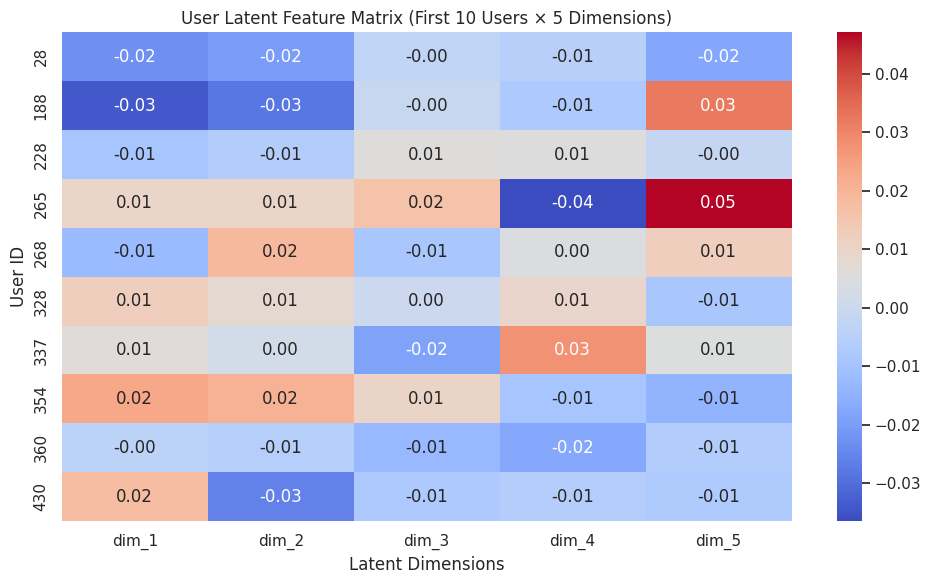

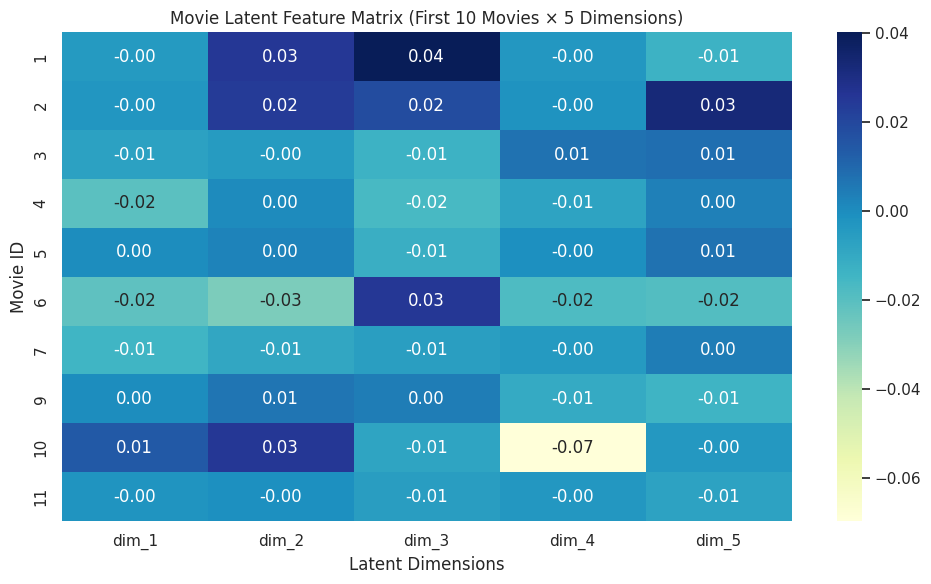

In [16]:
import seaborn as sns
import pandas as pd

# Visualize First Few Latent Dimensions for Users
# Convert U to DataFrame for visualization
user_latent_df = pd.DataFrame(U, index=best_matrix.index, columns=[f"dim_{i+1}" for i in range(U.shape[1])])

# Heatmap of first 10 users and first 5 latent dimensions
plt.figure(figsize=(10, 6))
sns.heatmap(user_latent_df.iloc[:10, :5], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("User Latent Feature Matrix (First 10 Users × 5 Dimensions)")
plt.xlabel("Latent Dimensions")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

# Visualize Latent Features of First Few Movies
# Transpose Vt to get movie × latent features
movie_latent_df = pd.DataFrame(Vt.T, index=best_matrix.columns, columns=[f"dim_{i+1}" for i in range(Vt.shape[0])])

plt.figure(figsize=(10, 6))
sns.heatmap(movie_latent_df.iloc[:10, :5], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Movie Latent Feature Matrix (First 10 Movies × 5 Dimensions)")
plt.xlabel("Latent Dimensions")
plt.ylabel("Movie ID")
plt.tight_layout()
plt.show()




#### 7.3. Annotated Heatmap of Movie Latent Features (with Titles)

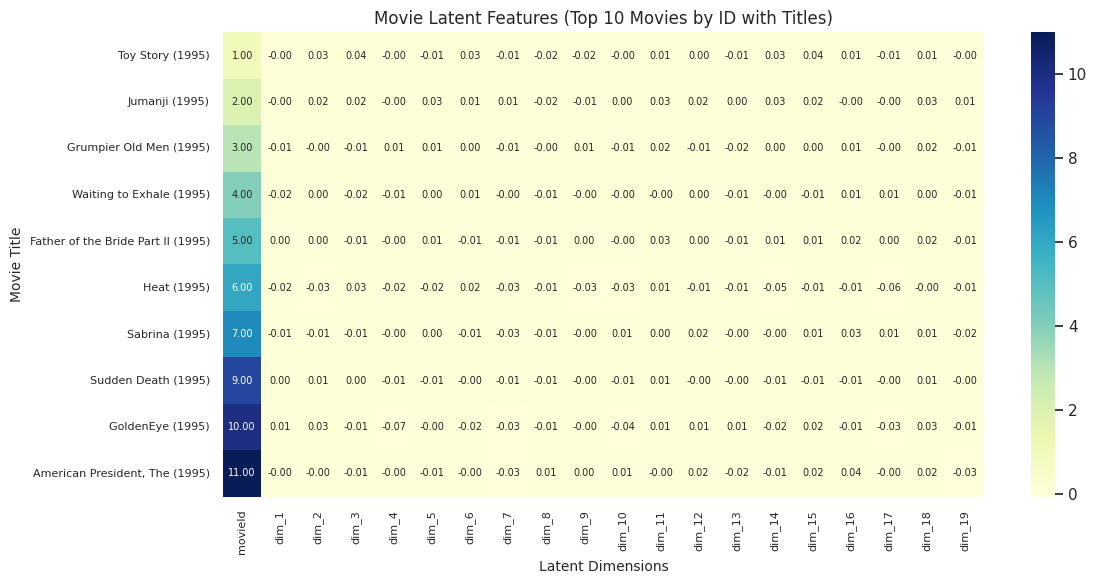

In [20]:
# Load movies.csv if not already loaded
movies = pd.read_csv("movies.csv")

# Merge titles with latent features
movie_latent_df = pd.DataFrame(Vt.T, index=best_matrix.columns, columns=[f"dim_{i+1}" for i in range(Vt.shape[0])])
movie_latent_df = movie_latent_df.reset_index().rename(columns={'movieId': 'movieId'})
movie_latent_annotated = pd.merge(movie_latent_df, movies[['movieId', 'title']], left_on='movieId', right_on='movieId')
movie_latent_annotated.set_index('title', inplace=True)

# Plot Heatmap with Titles
# Plot Heatmap with Smaller Font Size
plt.figure(figsize=(12, 6))
sns.heatmap(
    movie_latent_annotated.iloc[:10, :-1],
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    annot_kws={"size": 7}  # Smaller annotation font
)
plt.title("Movie Latent Features (Top 10 Movies by ID with Titles)", fontsize=12)
plt.xlabel("Latent Dimensions", fontsize=10)
plt.ylabel("Movie Title", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()



#### 7.4. Compare Different k Values Side-by-Side

Running SVD for each k...



100%|██████████| 14/14 [09:14<00:00, 39.59s/it]


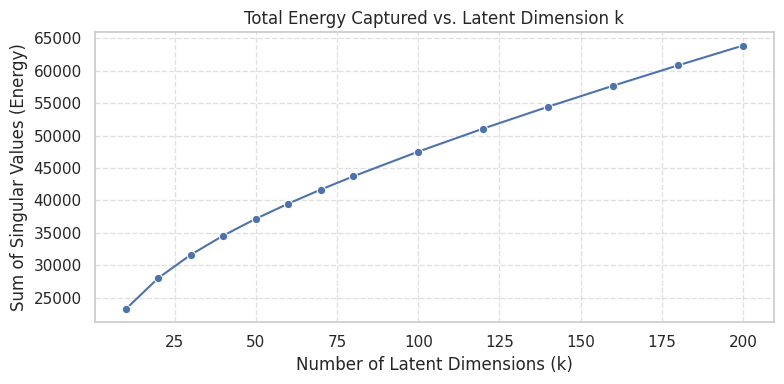

In [25]:
from scipy.sparse.linalg import svds
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step A: SVD Energy Function with Silent Iteration
def svd_energy(matrix, k_values):
    energy_data = []

    print("Running SVD for each k...\n")
    for k in tqdm(k_values):
        U, sigma, Vt = svds(matrix, k=k)
        total_energy = np.sum(sigma)
        energy_data.append((k, total_energy))

    return pd.DataFrame(energy_data, columns=['k', 'total_energy'])

# Step B: Run for Multiple k Values and Plot
k_vals = [10, 20, 30, 40, 50, 60, 70, 80, 100, 120, 140, 160, 180, 200]
energy_df = svd_energy(sparse_matrix, k_vals)

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=energy_df, x='k', y='total_energy', marker='o')
plt.title("Total Energy Captured vs. Latent Dimension k")
plt.xlabel("Number of Latent Dimensions (k)")
plt.ylabel("Sum of Singular Values (Energy)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
